In [ ]:
!pip install pandas numpy xgboost scikit-learn matplotlib

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

Mean Absolute Error (MAE): 22.02

Results saved to predicted_vs_actual_all_items_safe.csv


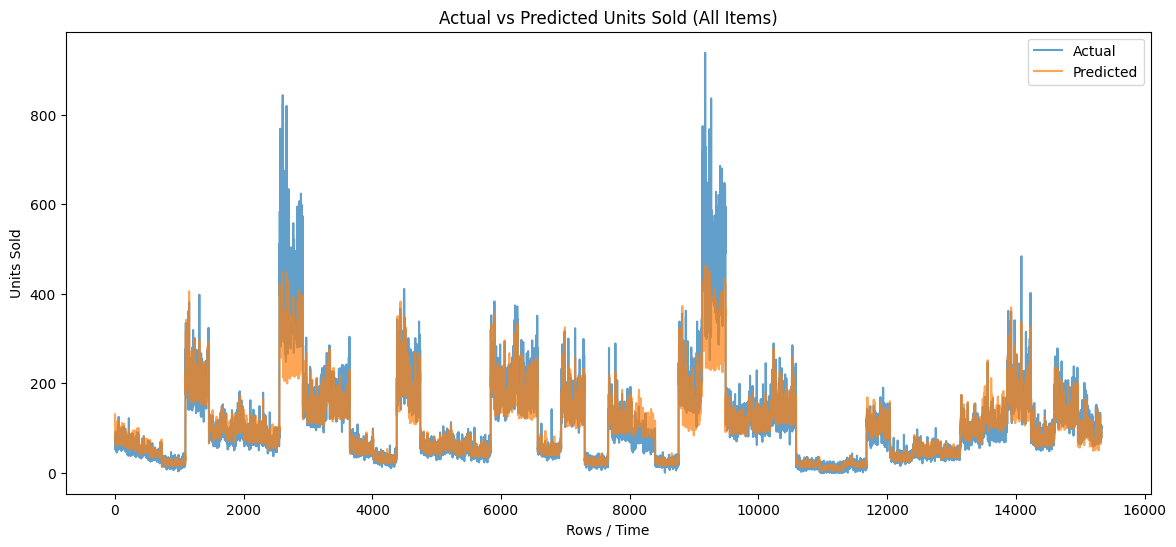

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

def run_demand_prediction_pipeline_safe(file_path='my_data.csv'):
    # ------------------------
    # Step 1: Load & clean data
    # ------------------------
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date', 'units_sold'])
    df = df.sort_values(['restaurant_id', 'food_name', 'date']).reset_index(drop=True)

    # ------------------------
    # Step 2: Create unique item ID
    # ------------------------
    df['item_id'] = df['restaurant_id'] + '_' + df['food_name']

    # ------------------------
    # Step 3: Feature Engineering (Safe)
    # ------------------------
    df['units_sold_lag_1'] = df.groupby('item_id')['units_sold'].shift(1)
    df['units_sold_lag_7'] = df.groupby('item_id')['units_sold'].shift(7)
    df['rolling_avg_7'] = df.groupby('item_id')['units_sold'].shift(1).rolling(7, min_periods=1).mean()

    # Fill lag/rolling missing values safely
    df['units_sold_lag_1'] = df['units_sold_lag_1'].fillna(0)
    df['units_sold_lag_7'] = df['units_sold_lag_7'].fillna(0)
    df['rolling_avg_7'] = df['rolling_avg_7'].fillna(0)

    # Time-based features
    df['day_of_week'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter

    # ------------------------
    # Step 4: Define features and target
    # ------------------------
    target = 'units_sold'
    categorical_features = [
        'season', 'climate', 'restaurant_id', 'restaurant_locality',
        'food_name', 'category', 'veg_nonveg', 'meal_type', 'hot_cold', 'is_chefspecial',
        'is_holiday', 'is_festival', 'holiday_religion'
    ]
    numerical_features = [
        'day_of_week', 'is_weekend', 'month', 'working_day', 'dish_popularity',
        'rating', 'price_per_unit', 'price_mean', 'units_sold_lag_1', 'units_sold_lag_7', 'rolling_avg_7'
    ]
    features = categorical_features + numerical_features
    X = df[features]
    y = df[target]

    # ------------------------
    # Step 5: Chronological train/test split
    # ------------------------
    train_size = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # ------------------------
    # Step 6: Preprocessing & Model Pipeline
    # ------------------------
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ], remainder='passthrough')

    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        n_jobs=-1,
        random_state=42
    )

    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('model', xgb_model)
    ])

    # ------------------------
    # Step 7: Train the model
    # ------------------------
    pipeline.fit(X_train, y_train)

    # ------------------------
    # Step 8: Predict and evaluate
    # ------------------------
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")

    # ------------------------
    # Step 9: Compile results
    # ------------------------
    results = pd.DataFrame({
        'Date': df['date'].iloc[train_size:],
        'Restaurant_Food': df['item_id'].iloc[train_size:],
        'Actual_Units_Sold': y_test.values,
        'Predicted_Units_Sold': y_pred
    }).reset_index(drop=True)

    results.to_csv('predicted_vs_actual_all_items_safe.csv', index=False)
    print("\nResults saved to predicted_vs_actual_all_items_safe.csv")

    # ------------------------
    # Step 10: Plot Actual vs Predicted
    # ------------------------
    plt.figure(figsize=(14,6))
    plt.plot(results['Actual_Units_Sold'].values, label='Actual', alpha=0.7)
    plt.plot(results['Predicted_Units_Sold'].values, label='Predicted', alpha=0.7)
    plt.title('Actual vs Predicted Units Sold (All Items)')
    plt.xlabel('Rows / Time')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.show()

# Run the pipeline
run_demand_prediction_pipeline_safe('my_data.csv')


Mean Absolute Error (MAE): 9.10
Mean Absolute Percentage Error (MAPE): 78400098140160000.00%

Results for a single food item: R3_Kheer (small bowl)
            Date        Restaurant_Food  Actual_Units_Sold  \
182   2023-10-22  R3_Kheer (small bowl)                 51   
393   2023-10-23  R3_Kheer (small bowl)                 49   
603   2023-10-24  R3_Kheer (small bowl)                 46   
811   2023-10-25  R3_Kheer (small bowl)                 51   
1023  2023-10-26  R3_Kheer (small bowl)                 43   
...          ...                    ...                ...   
14041 2023-12-27  R3_Kheer (small bowl)                 76   
14253 2023-12-28  R3_Kheer (small bowl)                 66   
14464 2023-12-29  R3_Kheer (small bowl)                 87   
14672 2023-12-30  R3_Kheer (small bowl)                 71   
14884 2023-12-31  R3_Kheer (small bowl)                 85   

       Predicted_Units_Sold  
182               59.765503  
393               47.808880  
603              

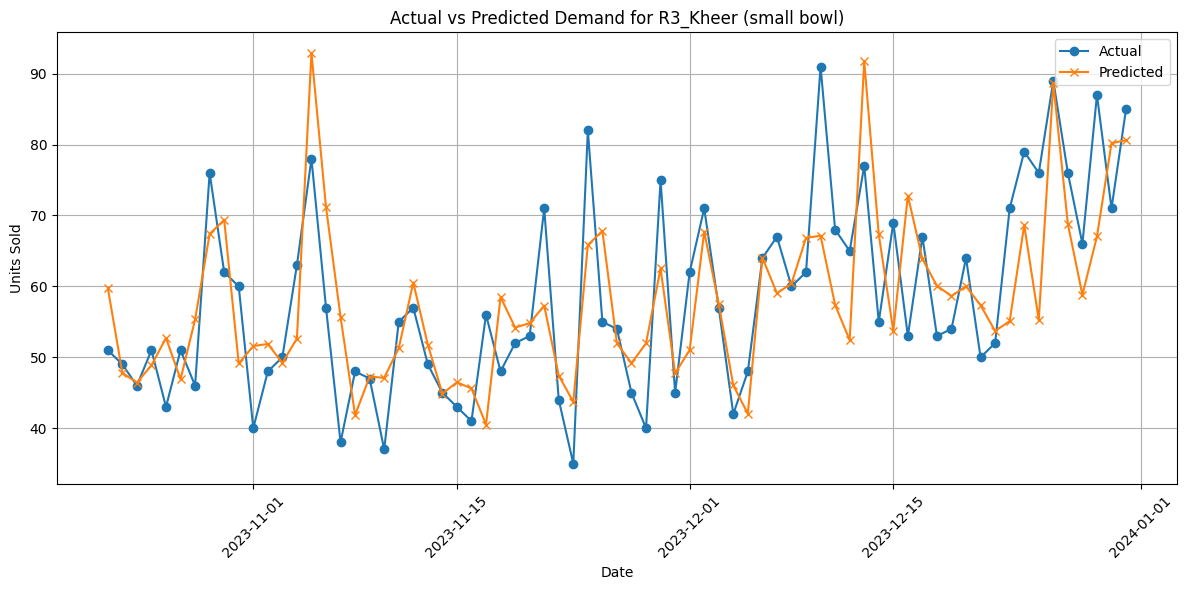

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def run_demand_prediction_pipeline(file_path='my_data.csv'):
    # ----------------------------
    # Step 1: Load & Clean Data
    # ----------------------------
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])
    df = df.sort_values('date').reset_index(drop=True)
    df['holiday_religion'] = df['holiday_religion'].fillna('None')
    df['item_id'] = df['restaurant_id'] + '_' + df['food_name']

    # ----------------------------
    # Step 2: Feature Engineering
    # ----------------------------
    df['units_sold_lag_1'] = df.groupby('item_id')['units_sold'].shift(1)
    df['units_sold_lag_7'] = df.groupby('item_id')['units_sold'].shift(7)
    df['rolling_avg_7'] = df.groupby('item_id')['units_sold'].shift(1).rolling(7).mean()
    df['day_of_week'] = df['date'].dt.weekday
    df['quarter'] = df['date'].dt.quarter
    df = df.dropna()

    # ----------------------------
    # Step 3: Define features and target
    # ----------------------------
    target = 'units_sold'
    categorical_features = ['season', 'climate', 'restaurant_id', 'restaurant_locality',
                            'food_name', 'category', 'veg_nonveg', 'meal_type', 'hot_cold',
                            'is_chefspecial', 'is_holiday', 'is_festival', 'holiday_religion']
    numerical_features = ['day_of_week', 'is_weekend', 'month', 'working_day', 'dish_popularity',
                          'rating', 'price_per_unit', 'price_mean', 'units_sold_lag_1',
                          'units_sold_lag_7', 'rolling_avg_7']
    features = categorical_features + numerical_features
    X = df[features]
    y = df[target]

    # ----------------------------
    # Step 4: Split train and test chronologically
    # ----------------------------
    train_size = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # ----------------------------
    # Step 5: Preprocessing & Model Pipeline
    # ----------------------------
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough')

    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        n_jobs=-1,
        random_state=42
    )

    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('model', xgb_model)
    ])

    # ----------------------------
    # Step 6: Train, predict, and evaluate
    # ----------------------------
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")

    # ----------------------------
    # Step 7: Create a DataFrame for results
    # ----------------------------
    results = pd.DataFrame({
        'Date': df['date'].iloc[train_size:],
        'Restaurant_Food': df['item_id'].iloc[train_size:],
        'Actual_Units_Sold': y_test,
        'Predicted_Units_Sold': y_pred
    })
    results = results.reset_index(drop=True)

    # ----------------------------
    # Step 8: Filter and visualize for a single food item
    # ----------------------------
    selected_food_item = 'R3_Kheer (small bowl)'
    filtered_results = results[results['Restaurant_Food'] == selected_food_item].copy()

    print(f"\nResults for a single food item: {selected_food_item}")
    print(filtered_results)

    # Plotting for the single food item
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_results['Date'], filtered_results['Actual_Units_Sold'], label='Actual', marker='o')
    plt.plot(filtered_results['Date'], filtered_results['Predicted_Units_Sold'], label='Predicted', marker='x')
    plt.title(f'Actual vs Predicted Demand for {selected_food_item}')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results

# Run the pipeline
results_df = run_demand_prediction_pipeline('my_data.csv')